# imports

In [22]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy

# variables

In [23]:
mass: float = 3
time_step: float = 0.01  # dt
iterations: int = 10_000  # higher values produce unrealistic gain values. part of the job is choosing a reasonable total time to simulate
COM = 0.1
rotational_inertia: float = 3
wind_speed_average: float = 3 
wind_speed_varience: float = 0.5
initial_kinematic_data: dict = {"pitch": 30, "pitch_velocity": 0}  # in degrees
# the following is [pitch, pitch_velocity, EDF_force]
filtervalues: list = [1, 0, 0]  # these give different weightings to different facors in the optimisation proccess
thrust: float = 4

# motion class

In [24]:
class motion(object):
    """
    Produce the simulation

    Args:
        object (_type_): _description_
    """
    def __init__(
        self,
        time_step: float,
        iterations: float,
        COM,
        rotational_inertia: float,
        wind_speed_average: float,
        wind_speed_varience: float,
        initial_kinematic_data: dict,
        gainvalues: dict,
        filtervalues: dict,
    ) -> None:
        
        self.time_step: float = time_step
        self.iterations: float = iterations
        self.COM = COM
        self.rot_inertia: float = rotational_inertia
        self.wind_speed_average: float =  wind_speed_average
        self.wind_speed_varience: float = wind_speed_varience
        self.pitch: float = [initial_kinematic_data["pitch"]]
        self.pitch_vel: float = [initial_kinematic_data["pitch_velocity"]]
        self.K_i: float = gainvalues[0]
        self.K_p: float = gainvalues[1]
        self.K_d: float = gainvalues[2]
        self.filtervalues: dict = filtervalues
        self.total_forces: list = [0]
        self.total_error: list = [0]

    ####################

    def wind(self) -> float:  # TODO correct method doctring
        """
        Simulate wind in the full simulation.

        wind really messes the gain values, so exclude from the gain value
        search but include in other simulations to test sturdiness of gain
        values
        
        Returns:
            _type_: _description_
        """
        translational_constant: float = 0.0
        wind_t = translational_constant*np.random.normal(
                                                        self.wind_speed_average,
                                                        self.wind_speed_varience
                                                        )
        return wind_t  # TODO figure out what the variable type is for this

    ####################

    def rotate(self, i):  # TODO what is i here? and also fill out method doctring
        """
        _summary_

        Args:
            i (_type_): _description_

        Returns:
            _type_: _description_
        """
        angular_rot: float = ((math.pi / 180) * self.pitch[i]
                              * self.COM * self.rot_inertia)
        return angular_rot
    
    ####################
    
    def TVC(self, i) -> float: # TODO again what is i here? use more descriptive variable names
        """
        _summary_

        Args:
            i (_type_): _description_

        Returns:
            _type_: _description_
        """ # TODO fill out method docstring
        if i > 0:
            total: float = self.rot_inertia * ((self.K_d * self.pitch_vel[i]
                                                + self.K_p * self.pitch[i]
                                                + self.K_i
                                                * sum(self.pitch[:100]) 
                                                / 100) / (self.COM))

            if total > 0.5 * thrust: 
                total: float = 0.5 * thrust
            if total < -0.5 * thrust:
                total: float  = -0.5 * thrust

            return -1 * total
        
        else:
            return 0
        
    ####################

    def forces(self, i) -> float:  # TODO what is i and also fill out method doctring
        """
        _summary_

        Args:
            i (_type_): _description_

        Returns:
            float: _description_
        """
        total = self.TVC(i) + self.wind() + self.rotate(i)
        self.total_forces.append(total)
        return total

    ####################

    def simulation(self, j):  # TODO what is j here? and also fill out method doctring
        """
        _summary_

        Args:
            j (_type_): _description_

        Returns:
            _type_: _description_
        """
        total = 0
        
        for i in range(0,self.iterations):
            next_pitch_vel = self.pitch_vel[i] + self.time_step * self.forces(i)
            
            next_pitch = self.pitch[i] + self.time_step * next_pitch_vel
            
            self.pitch.append(next_pitch)
            self.pitch_vel.append(next_pitch_vel)
            
            total += self.filter([next_pitch,
                                  next_pitch_vel,
                                  next_pitch_vel - self.pitch_vel[i]]
                                 )
            
            self.total_error.append(total)

        if j == 0:
            return total

        if j == 1:
            return self.pitch

        if j == 2:
            return (self.pitch,
                    self.pitch_vel,
                    self.total_forces,
                    self.total_error
                    ) 
    
    ####################
    
    def filter(self, rotational_data) -> float:  # TODO fill out method docstring
        """
        _summary_

        Args:
            rotational_data (_type_): _description_

        Returns:
            float: _description_
        """
        filter_value = 0
        
        for i in range(0, len(rotational_data)):
            filter_value += self.filtervalues[i] * (rotational_data[i]) ** 2
        
        return filter_value

# other functions

In [25]:
def gain(gainvalues):  # TODO fill out method doctring
    """
    Begin simulations.

    Args:
        gainvalues (_type_): _description_

    Returns:
        _type_: _description_
    """
    simulation: motion = motion(time_step,
                        iterations,
                        COM,
                        rotational_inertia,
                        wind_speed_average,
                        wind_speed_varience,
                        initial_kinematic_data,
                        gainvalues,
                        filtervalues
                        )
    
    total_pitch_squared: float = simulation.simulation(0)
    return total_pitch_squared

########################################

def optimise() -> None:
    """
    Produce optial gain values for the simulation.
    """
    initial_guess = [0,0,0]
    simulation = scipy.optimize.minimize(gain,
                                         initial_guess,
                                         method='BFGS',
                                         tol = 0.01
                                         )
    
    print(simulation.x)
    model = str(input("Would you like to simulate with these gain values? \n"
                      "type 'yes' or 'no' to continue"))
    
    if model == "yes":
        plot(simulation.x)
    
    elif model != "no" and model != "yes":
        print("Error: invalid input. Please try again.")

########################################

def plot(gainvalues): # TODO fill out method doctring
    """
    Manually input gain values for simulation.

    Args:
        gainvalues (_type_): _description_
    """
    simulation = motion(time_step,
                        iterations,
                        COM,
                        rotational_inertia,
                        wind_speed_average,
                        wind_speed_varience,
                        initial_kinematic_data,
                        gainvalues,
                        filtervalues
                        )
    
    pitch, pitch_vel, forces, error = simulation.simulation(2)
    
    time = []
    
    for i in range(0, len(pitch)):
        time.append(time_step*i)

    # plot the data
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(time, pitch)
    ax1.set_ylabel("Pitch [degs]")
    ax1.set_xlabel("Time [s]")
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(time, pitch_vel) 
    ax2.set_ylabel("Pitch Velocity [degs/s]")
    ax2.set_xlabel("Time [s]")
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(time, forces)
    ax3.set_ylabel("Angular Forces [Nm]")
    ax3.set_xlabel("Time [s]")
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.plot(time, error)
    ax4.set_ylabel("Total Gain Errors [unitless]")
    ax4.set_xlabel("Time[s]")
    plt.show()


# main function

[-4.65501617e-05  1.05492557e-01  1.85576059e-01]


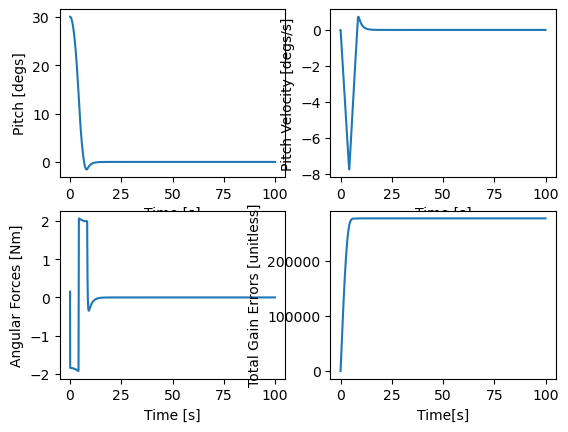

In [26]:
def main():
    i = int(input("Please select one of the following options: \n"
                  "0: Optimise gain values \n"
                  "1: Manually input gain values \n"))
    
    if i == 0:
        optimise()

    if i == 1:
        gainvalues = [-0.00503818,  2.19397827,  1.24042202]
        plot(gainvalues)


if __name__ == "__main__":
    main()